In [1]:
 #from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, Multiply
from tensorflow.keras import backend as K
import cv2, numpy as np
import glob
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu 
import keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,add

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
 
import os
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf

from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from tensorflow.keras import backend as K
from pathlib import Path
 
from tensorflow.keras import optimizers

import numpy as np
 
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

tf.random.Generator = None 
import tensorflow_addons as tfa


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

In [3]:
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
from keras.callbacks import LambdaCallback 

In [5]:
from vgg_bn   import VGG16_BN
from vgg_wbn  import VGG16_wBN  
 

In [6]:
 
weight_decay = 1e-4
lr = 1e-1
num_classes = 10
model = VGG16_wBN(input_tensor=None, input_shape=x_train.shape[1:], classes=num_classes, conv_dropout=0.1, dropout=0.3, activation='relu')


In [7]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
BATCHSIZE = 128
batch_size=128
it_train = datagen.flow(x_train, y_train, batch_size=128)
steps = int(x_train.shape[0] / BATCHSIZE) 

it_val = datagen.flow(x_test, y_test, batch_size=128)

In [8]:
batch_print_callback = LambdaCallback(on_epoch_end=lambda epoch,logs: model.layers[0].get_weights())

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


filepath="Bv.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

#lr_scheduler = LearningRateScheduler(lr_scheduler)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint,batch_print_callback  ]

In [10]:
len(model.layers)

55

In [12]:
# model.summary()

## With Batchnorm

In [13]:
model = VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=num_classes, conv_dropout=0.1, dropout=0.3, activation='relu')

In [14]:
ep=5 


lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient_b = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient_b.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[0])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hb1=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])



 

  


  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 45s 114ms/step - loss: 2.2206 - accuracy: 0.2118 - val_loss: 3.6963 - val_accuracy: 0.1042
Epoch 2/5
390/390 [==============================] - 39s 100ms/step - loss: 1.7831 - accuracy: 0.3379 - val_loss: 2.6528 - val_accuracy: 0.2024
Epoch 3/5
390/390 [==============================] - 39s 101ms/step - loss: 1.5988 - accuracy: 0.4116 - val_loss: 2.2919 - val_accuracy: 0.2665
Epoch 4/5
390/390 [==============================] - 39s 101ms/step - loss: 1.4845 - accuracy: 0.4580 - val_loss: 1.9766 - val_accuracy: 0.3405
Epoch 5/5
390/390 [==============================] - 40s 102ms/step - loss: 1.3803 - accuracy: 0.4997 - val_loss: 1.7488 - val_accuracy: 0.3928


In [37]:
g1_wb=np.asarray(epoch_gradient_b)



In [38]:
lid=53 #28 to, comapre we have to select the layer with sam property
epid=4
bchid=340

g1_wb=g1_wb[epid][bchid][lid]

g1_wb.shape

(512,)

In [39]:
 


lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient_b = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient_b.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[1])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hb2=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])


g2_wb=np.asarray(epoch_gradient_b)
g2_wb=g2_wb[epid][bchid][lid]
 

  
 

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 43s 110ms/step - loss: 1.3683 - accuracy: 0.5084 - val_loss: 1.3024 - val_accuracy: 0.5658
Epoch 2/5
390/390 [==============================] - 39s 101ms/step - loss: 1.1096 - accuracy: 0.6069 - val_loss: 1.1294 - val_accuracy: 0.6225
Epoch 3/5
390/390 [==============================] - 40s 102ms/step - loss: 0.9664 - accuracy: 0.6629 - val_loss: 1.0018 - val_accuracy: 0.6512
Epoch 4/5
390/390 [==============================] - 39s 101ms/step - loss: 0.8618 - accuracy: 0.7048 - val_loss: 1.2261 - val_accuracy: 0.6023
Epoch 5/5
390/390 [==============================] - 40s 103ms/step - loss: 0.7873 - accuracy: 0.7307 - val_loss: 0.8339 - val_accuracy: 0.7084


In [40]:
 


lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient_b = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient_b.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[2])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hb3=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])


g3_wb=np.asarray(epoch_gradient_b)
g3_wb=g3_wb[epid][bchid][lid]
 

  
 

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 44s 114ms/step - loss: 1.6450 - accuracy: 0.3745 - val_loss: 1.9273 - val_accuracy: 0.3875
Epoch 2/5
390/390 [==============================] - 40s 103ms/step - loss: 1.1973 - accuracy: 0.5739 - val_loss: 1.3893 - val_accuracy: 0.5691
Epoch 3/5
390/390 [==============================] - 39s 101ms/step - loss: 0.9990 - accuracy: 0.6522 - val_loss: 0.9532 - val_accuracy: 0.6658
Epoch 4/5
390/390 [==============================] - 39s 101ms/step - loss: 0.8858 - accuracy: 0.6987 - val_loss: 1.0167 - val_accuracy: 0.6613
Epoch 5/5
390/390 [==============================] - 41s 105ms/step - loss: 0.8024 - accuracy: 0.7291 - val_loss: 0.8374 - val_accuracy: 0.7171


In [41]:
 


lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient_b = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient_b.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[3])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hb4=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])


g4_wb=np.asarray(epoch_gradient_b)
g4_wb=g4_wb[epid][bchid][lid]
 

  
 

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 44s 114ms/step - loss: 0.6545 - accuracy: 0.7804 - val_loss: 0.6088 - val_accuracy: 0.7972
Epoch 2/5
390/390 [==============================] - 41s 104ms/step - loss: 0.6062 - accuracy: 0.7957 - val_loss: 0.5939 - val_accuracy: 0.8013
Epoch 3/5
390/390 [==============================] - 40s 103ms/step - loss: 0.5814 - accuracy: 0.8036 - val_loss: 0.5713 - val_accuracy: 0.8126
Epoch 4/5
390/390 [==============================] - 41s 105ms/step - loss: 0.5611 - accuracy: 0.8111 - val_loss: 0.5451 - val_accuracy: 0.8202
Epoch 5/5
390/390 [==============================] - 40s 103ms/step - loss: 0.5460 - accuracy: 0.8152 - val_loss: 0.5553 - val_accuracy: 0.8130


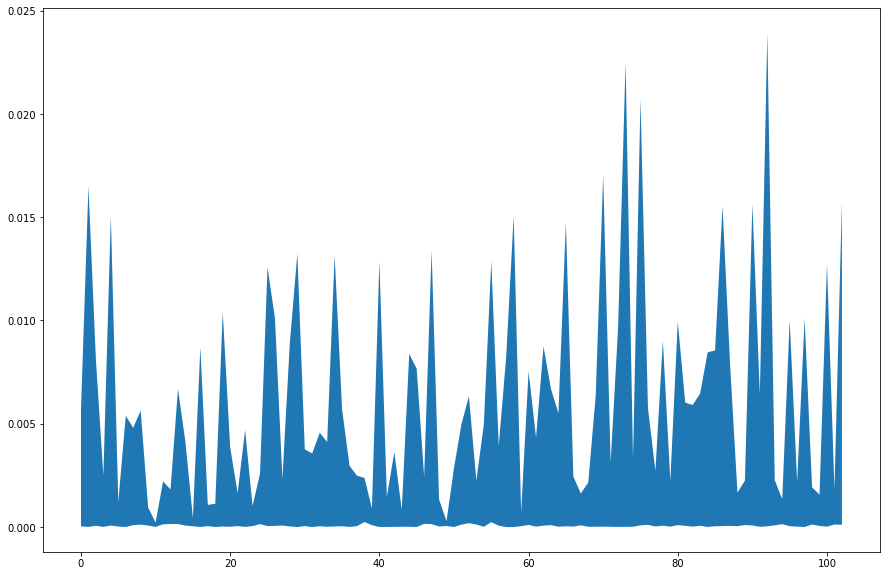

In [42]:
 

l1 = np.array(g1_wb).flatten()
l2 = np.array(g2_wb).flatten()
l3 = np.array(g3_wb).flatten()
l4 = np.array(g4_wb).flatten()

d1 = []
d2 = []
d3 = []
d4 = []
for i in range(1,len(l1)):
    d1.append(np.linalg.norm(l1[i-1] - l1[i]).item())
    d2.append(np.linalg.norm(l2[i-1] - l2[i]).item())
    d3.append(np.linalg.norm(l3[i-1] - l3[i]).item())
    d4.append(np.linalg.norm(l4[i-1] - l4[i]).item())
  
min_curve_b = []
max_curve_b = []
for i in range(len(d1)):
    min_curve_b.append(np.min([d1[i], d2[i], d3[i], d4[i]]))
    max_curve_b.append(np.max([d1[i], d2[i], d3[i], d4[i]])) 
    
    
    

plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve_b)//5+1), min_curve_b[::5], max_curve_b[::5])

## Without Batchnorm

In [43]:
 
weight_decay = 1e-4
lr = 1e-1
num_classes = 10
model = VGG16_wBN(input_tensor=None, input_shape=x_train.shape[1:], classes=num_classes, conv_dropout=0.1, dropout=0.3, activation='relu')


In [44]:
epoch_gradient_b = list()

In [45]:
 
ep=5

lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[0])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

h1=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])




  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 36s 93ms/step - loss: 2.0189 - accuracy: 0.2162 - val_loss: 2.2595 - val_accuracy: 0.1602
Epoch 2/5
390/390 [==============================] - 33s 86ms/step - loss: 1.7029 - accuracy: 0.3505 - val_loss: 2.1036 - val_accuracy: 0.2011
Epoch 3/5
390/390 [==============================] - 35s 89ms/step - loss: 1.5225 - accuracy: 0.4330 - val_loss: 1.6657 - val_accuracy: 0.3974
Epoch 4/5
390/390 [==============================] - 35s 89ms/step - loss: 1.4036 - accuracy: 0.4826 - val_loss: 1.6457 - val_accuracy: 0.4308
Epoch 5/5
390/390 [==============================] - 35s 90ms/step - loss: 1.3187 - accuracy: 0.5209 - val_loss: 1.5486 - val_accuracy: 0.4645


In [46]:
g1_nb=np.asarray(epoch_gradient)
 


In [51]:
lid=27
epid=4
bchid=340


g1=g1_nb[epid][bchid][lid]
g1.shape

(512,)

In [52]:
g1_nb=g1_nb[epid][bchid][lid]

In [53]:
 
ep=5

lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[1])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

h2=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])


g2_nb=np.asarray(epoch_gradient)
 
g2_nb=g2_nb[epid][bchid][lid]

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 36s 91ms/step - loss: 1.4205 - accuracy: 0.4842 - val_loss: 1.5300 - val_accuracy: 0.4644
Epoch 2/5
390/390 [==============================] - 35s 89ms/step - loss: 1.2544 - accuracy: 0.5502 - val_loss: 1.1383 - val_accuracy: 0.5837
Epoch 3/5
390/390 [==============================] - 33s 85ms/step - loss: 1.1206 - accuracy: 0.6031 - val_loss: 0.9699 - val_accuracy: 0.6529
Epoch 4/5
390/390 [==============================] - 34s 86ms/step - loss: 1.0149 - accuracy: 0.6398 - val_loss: 0.9066 - val_accuracy: 0.6849
Epoch 5/5
390/390 [==============================] - 33s 86ms/step - loss: 0.9359 - accuracy: 0.6730 - val_loss: 0.9812 - val_accuracy: 0.6757


In [54]:
 
ep=5

lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[2])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

h3=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])


g3_nb=np.asarray(epoch_gradient)
 
g3_nb=g3_nb[epid][bchid][lid]

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 36s 92ms/step - loss: 2.0106 - accuracy: 0.1960 - val_loss: 1.9352 - val_accuracy: 0.2116
Epoch 2/5
390/390 [==============================] - 34s 87ms/step - loss: 1.8945 - accuracy: 0.2183 - val_loss: 1.8740 - val_accuracy: 0.2269
Epoch 3/5
390/390 [==============================] - 34s 86ms/step - loss: 1.8210 - accuracy: 0.2594 - val_loss: 1.7377 - val_accuracy: 0.2912
Epoch 4/5
390/390 [==============================] - 33s 86ms/step - loss: 1.7491 - accuracy: 0.2921 - val_loss: 1.6791 - val_accuracy: 0.3384
Epoch 5/5
390/390 [==============================] - 33s 86ms/step - loss: 1.5989 - accuracy: 0.3607 - val_loss: 1.4734 - val_accuracy: 0.4232


In [55]:
 
ep=5

lra=[1e-4,5e-4,5e-3,1e-3]

 
epoch_gradient = list()
# Define the Gradient Function
def get_gradient_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, grads)
    return func

# Define the Required Callback Function
class GradientCalcCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        get_gradient = get_gradient_func(model)
        #grads = get_gradient([x_train, y_train, np.ones(len(y_train))])
        
        imdt=list()
        for i in range((int(x_train.shape[0] / BATCHSIZE))):
                        x_batch = x_train[i*batch_size:(i+1)*batch_size]
                        y_batch = y_train[i*batch_size:(i+1)*batch_size] 
                        grads_batch = get_gradient([x_batch, y_batch, np.ones(len(y_batch))])
                        imdt.append(grads_batch)
        
        epoch_gradient.append(np.asarray(imdt))


 
optimizer = Adam(lr= lra[3])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

h4=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [GradientCalcCallback() ])


g4_nb=np.asarray(epoch_gradient)
 
g4_nb=g4_nb[epid][bchid][lid]

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/5
390/390 [==============================] - 37s 95ms/step - loss: 1.4219 - accuracy: 0.4490 - val_loss: 1.4192 - val_accuracy: 0.4579
Epoch 2/5
390/390 [==============================] - 33s 86ms/step - loss: 1.3610 - accuracy: 0.4884 - val_loss: 1.3444 - val_accuracy: 0.4820
Epoch 3/5
390/390 [==============================] - 33s 86ms/step - loss: 1.2997 - accuracy: 0.5179 - val_loss: 1.3038 - val_accuracy: 0.4901
Epoch 4/5
390/390 [==============================] - 33s 86ms/step - loss: 1.2421 - accuracy: 0.5465 - val_loss: 1.3741 - val_accuracy: 0.5001
Epoch 5/5
390/390 [==============================] - 33s 86ms/step - loss: 1.1958 - accuracy: 0.5634 - val_loss: 1.2788 - val_accuracy: 0.5167


In [56]:
epoch_gradient = list()

Text(0.5, 1.0, 'Gradient Predictiveness without batch norm, values are 30 times downscaled for better visualization')

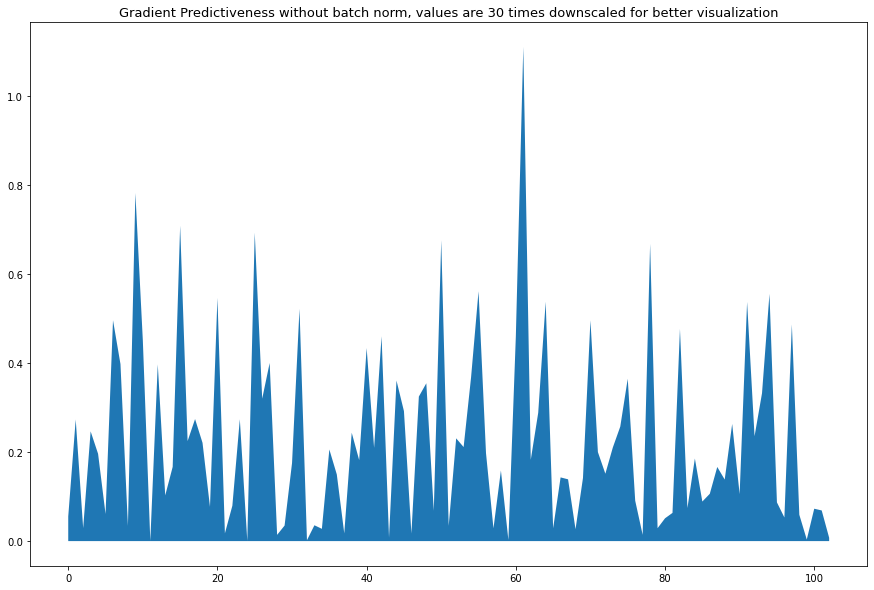

In [112]:


l1 = np.array(g1_nb).flatten()
l2 = np.array(g2_nb).flatten()
l3 = np.array(g3_nb).flatten()
l4 = np.array(g4_nb).flatten()

d1 = []
d2 = []
d3 = []
d4 = []
for i in range(1,len(l1)):
    d1.append(np.linalg.norm(l1[i-1] - l1[i]).item())
    d2.append(np.linalg.norm(l2[i-1] - l2[i]).item())
    d3.append(np.linalg.norm(l3[i-1] - l3[i]).item())
    d4.append(np.linalg.norm(l4[i-1] - l4[i]).item())
  
min_curve = []
max_curve = []
for i in range(len(d1)):
    min_curve.append(np.min([d1[i], d2[i], d3[i], d4[i]])/30)
    max_curve.append(np.max([d1[i], d2[i], d3[i], d4[i]])/30) 
    
    
    

plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve)//5+1), min_curve[::5], max_curve[::5])
plt.title('Gradient Predictiveness without batch norm, values are 30 times downscaled for better visualization', fontsize=13)

Text(0.5, 1.0, 'Gradient Predictiveness with batch norm, values are 10 times scaled for better visualization')

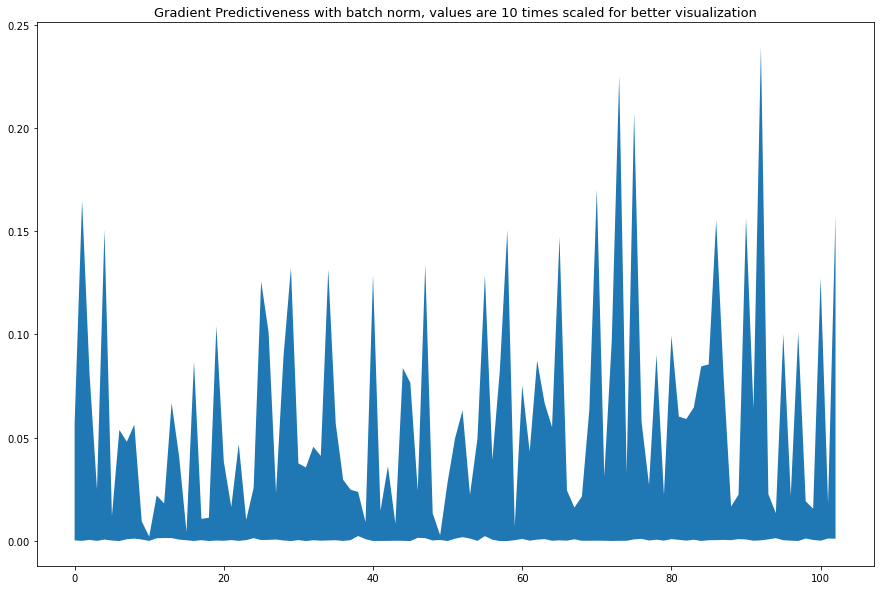

In [113]:
 

l1 = np.array(g1_wb).flatten()
l2 = np.array(g2_wb).flatten()
l3 = np.array(g3_wb).flatten()
l4 = np.array(g4_wb).flatten()

d1 = []
d2 = []
d3 = []
d4 = []
for i in range(1,len(l1)):
    d1.append(np.linalg.norm(l1[i-1] - l1[i]).item())
    d2.append(np.linalg.norm(l2[i-1] - l2[i]).item())
    d3.append(np.linalg.norm(l3[i-1] - l3[i]).item())
    d4.append(np.linalg.norm(l4[i-1] - l4[i]).item())
  
min_curve_b = []
max_curve_b = []
for i in range(len(d1)):
    min_curve_b.append(np.min([d1[i], d2[i], d3[i], d4[i]])*10)
    max_curve_b.append(np.max([d1[i], d2[i], d3[i], d4[i]])*10) 
    
 

plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve_b)//5+1), min_curve_b[::5], max_curve_b[::5])
plt.title('Gradient Predictiveness with batch norm, values are 10 times scaled for better visualization', fontsize=13)


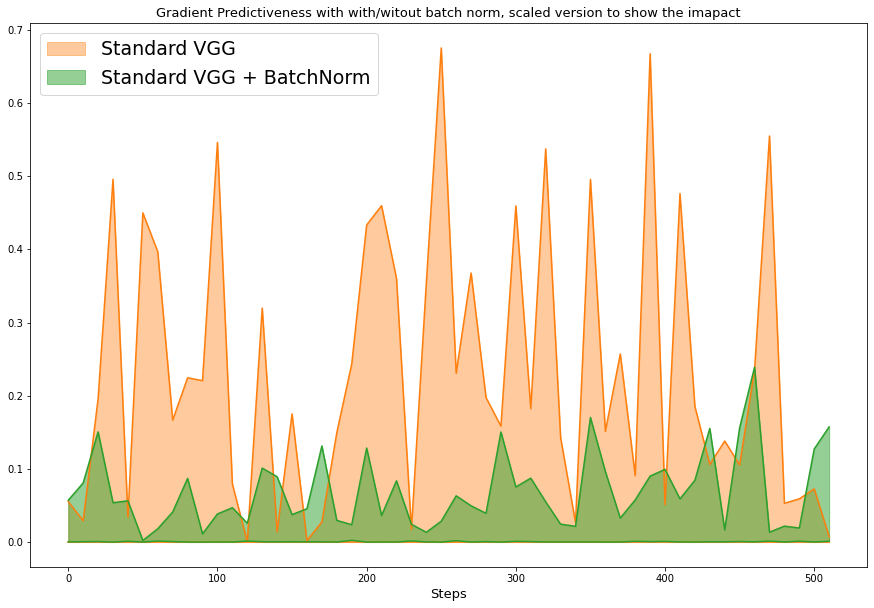

In [142]:
figures_path='fig/'
step = 10
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve[::step], max_curve[::step],
                alpha=.4, color='C1', label='Standard VGG')
plt.plot(steps, min_curve[::step], color='C1')
plt.plot(steps, max_curve[::step], color='C1')

plt.fill_between(steps, min_curve_b[::step], max_curve_b[::step],
                alpha=0.5, color='C2', label='Standard VGG + BatchNorm')
plt.plot(steps, min_curve_b[::step], color='C2')
plt.plot(steps, max_curve_b[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Gradient Predictiveness', fontsize=20)
 
plt.xlabel('Steps', fontsize=13)
plt.title('Gradient Predictiveness with with/witout batch norm, scaled version to show the imapact', fontsize=13)

plt.savefig(os.path.join(figures_path, 'gradient_predictiveness.png'), dpi=500, quality=100)
plt.show()

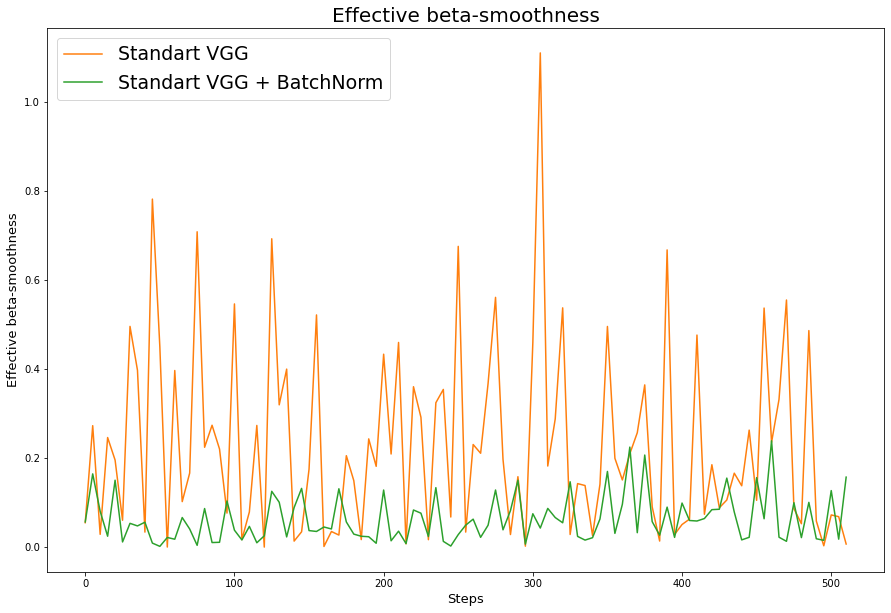

In [147]:

step = 5
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))

plt.plot(steps, max_curve[::step], color='C1', label='Standart VGG')

plt.plot(steps, max_curve_b[::step], color='C2', label='Standart VGG + BatchNorm')

plt.legend(fontsize=19)
plt.title('Effective beta-smoothness', fontsize=20)
plt.ylabel('Effective beta-smoothness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'effective_beta_smoothness.png'), dpi=500, quality=100)
plt.show() 